In [1]:
import sys
import os
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path + "/src/simulations_v2")

from analysis_helpers import poisson_waiting_function, \
                            run_multiple_trajectories, \
                            plot_aip_vs_t, \
                            plot_cip_vs_t, \
                            run_sensitivity_sims, \
                            extract_cips

from stochastic_simulation import StochasticSimulation
from sir_stochastic_sim import SIRStochasticSimulation
from subdivide_severity import subdivide_severity

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size'] = 12

def plot_trajectories(dfs, title, params, color='green', alpha = 0.1, cumulative=True, free=False):
    plt.xlabel("Day")
    plt.ylabel("Number of Active Infections")
    plt.title(title)
    for df in dfs:
        add_plot(df, params, color=color, alpha = alpha, cumulative = cumulative, free=free)

def plot_trajectories_recovered(dfs, title, params, color='green', alpha = 0.1):
    plt.xlabel("Day")
    plt.ylabel("Number of Active Infections")
    plt.title(title)
    for df in dfs:
        add_plot_recovered(df, params, color=color, alpha = alpha)
        
def add_plot(df, params, color='blue', alpha = 0.1, cumulative = True, free = False):
    if cumulative:
        cols = ['QI','R'] + ['E_{}'.format(x) for x in range(params['max_time_exposed'])] + \
                ['ID_{}'.format(x) for x in range(params['max_time_ID'])] + \
                ['pre_ID_{}'.format(x) for x in range(params['max_time_pre_ID'])] + \
                ['SyID_mild_{}'.format(x) for x in range(params['max_time_SyID_mild'])] + \
                ['SyID_severe_{}'.format(x) for x in range(params['max_time_SyID_severe'])]
    elif free == False:
        cols = ['QI'] + ['E_{}'.format(x) for x in range(params['max_time_exposed'])] + \
                ['ID_{}'.format(x) for x in range(params['max_time_ID'])] + \
                ['pre_ID_{}'.format(x) for x in range(params['max_time_pre_ID'])] + \
                ['SyID_mild_{}'.format(x) for x in range(params['max_time_SyID_mild'])] + \
                ['SyID_severe_{}'.format(x) for x in range(params['max_time_SyID_severe'])]
    else:
        # Total infectous population
        cols = ['ID_{}'.format(x) for x in range(params['max_time_ID'])] + \
                ['SyID_mild_{}'.format(x) for x in range(params['max_time_SyID_mild'])] + \
                ['SyID_severe_{}'.format(x) for x in range(params['max_time_SyID_severe'])]
    plt.plot(df[cols].sum(axis=1), linewidth=10.0, alpha=alpha, color=color)
        
def add_plot_recovered(df, params, color='blue', alpha = 0.1):
    cols = ['R']
    plt.plot(df[cols].sum(axis=1), linewidth=10.0, alpha=alpha, color=color)
    
    
#     if ID_only:
#         cols = ['ID_{}'.format(x) for x in range(params['max_time_ID'])]
#     else:
#         cols = ['ID_{}'.format(x) for x in range(params['max_time_ID'])] + \
#                 ['pre_ID_{}'.format(x) for x in range(params['max_time_pre_ID'])]
    plt.plot(df[cols].sum(axis=1), linewidth=10.0, alpha=alpha, color=color)
    

In [3]:
# in reality I think this value will vary a lot in the first few days, 
# and then reach some kind of steady-state, and I'm not sure what makes the most
# sense to use here.  I am setting it to the very pessimistic value of 100% of
# self-reporters are severe, which yields the smallest infectious window size

'''
pct_self_reports_severe = 1

daily_self_report_severe = 0.8
daily_self_report_mild = 0

# avg_infectious_window = (avg time in ID state) + (avg time in Sy state prior to self-reporting)
avg_infectious_window = 4 + pct_self_reports_severe * (1 / daily_self_report_severe) 
if daily_self_report_mild != 0:
    avg_infectious_window += (1 - pct_self_reports_severe) * (1 / daily_self_report_mild)
pre_reopen_population = 2500
pre_reopen_daily_contacts = 7


prob_severity_given_age = np.array([[0.05, 0.94, 0.01, 0],\
                                    [0.04, 0.83, 0.10, 0.03],\
                                    [0.04, 0.79, 0.10, 0.07],\
                                    [0.04, 0.73, 0.13, 0.10],\
                                    [0.03, 0.57, 0.2, 0.2]])

prob_infection = np.array([0.018, 0.022, 0.029, 0.042, 0.042])
prob_age = np.array([0, 0.6534332, 0.3221892, 0.0209788, 0.0033988])

post_reopen_population = 2500
post_reopen_daily_contacts = 10

base_params = {
    'max_time_exposed': 4,
    'exposed_time_function': poisson_waiting_function(max_time=4, mean_time=2),
    
    'max_time_pre_ID': 4,
    'pre_ID_time_function': poisson_waiting_function(max_time=4, mean_time=0),
    
    'max_time_ID': 8,
    'ID_time_function': poisson_waiting_function(max_time=8, mean_time=3),
    
    'max_time_SyID_mild': 14,
    'SyID_mild_time_function': poisson_waiting_function(max_time=14, mean_time=10),
    
    'max_time_SyID_severe': 14,
    'SyID_severe_time_function': poisson_waiting_function(max_time=14, mean_time=10),
    
    'sample_QI_exit_function': (lambda n: np.random.binomial(n, 0.05)),
    'sample_QS_exit_function': (lambda n: np.random.binomial(n, 0.3)),
    
    'exposed_infection_p': 0.026,
    'expected_contacts_per_day': post_reopen_daily_contacts,
    
    'mild_severity_levels': 1,
    'severity_prevalence': subdivide_severity(prob_severity_given_age, prob_infection, prob_age),
    'mild_symptoms_daily_self_report_p': daily_self_report_mild,
    'severe_symptoms_daily_self_report_p': daily_self_report_severe,
    
    'days_between_tests': 300,
    'test_population_fraction': 0,
    
    'test_protocol_QFNR': 0.1,
    'test_protocol_QFPR': 0.005,
    
    'perform_contact_tracing': False,
    'contact_tracing_constant': 0.5,
    'contact_tracing_delay': 1,
    'contact_trace_infectious_window': avg_infectious_window,
    
    'pre_ID_state': 'detectable',
    
    'population_size': post_reopen_population,
    'initial_E_count': 0,
    'initial_pre_ID_count': 0,
    'initial_ID_count': 0,
    'initial_ID_prevalence': 0.01,
    'initial_SyID_mild_count': 0,
    'initial_SyID_severe_count': 0
}
'''

from june_realistic import base_params
# from fall_realistic import base_params

# No interventions (only self-reporting)

In [4]:
# run 1 trajectory
params = base_params.copy()
params['days_between_tests'] = 300
# params['perform_contact_tracing'] = False
np.random.seed(15)
dfs_sims = run_multiple_trajectories(params, ntrajectories=1, time_horizon=150)

,S,QS,QI,R,E_0,E_1,E_2,E_3,pre_ID_0,pre_ID_1,...,SyID_severe_12,SyID_severe_13,SyID_severe_14,SyID_severe_15,cumulative_mild,cumulative_severe,severity_0,severity_1,severity_2,severity_3
0,2493,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0.850654,0.108314,0.0410329
1,2490,0,0,0,1,0,1,0,0,0,...,0,0,1,0,0,1,0,0.850654,0.108314,0.0410329
2,2485,0,0,0,2,2,1,1,0,0,...,0,1,0,0,0,2,0,1.70131,0.216627,0.0820657
3,2481,0,1,0,2,3,2,1,0,0,...,0,0,0,0,0,2,0,1.70131,0.216627,0.0820657
4,2471,5,3,0,3,2,3,0,0,0,...,0,0,0,0,1,3,1,2.55196,0.324941,0.123099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
146,2363,0,0,137,0,0,0,0,0,0,...,0,0,0,0,6,131,6,111.436,14.1891,5.37531
147,2363,0,0,137,0,0,0,0,0,0,...,0,0,0,0,6,131,6,111.436,14.1891,5.37531
148,2363,0,0,137,0,0,0,0,0,0,...,0,0,0,0,6,131,6,111.436,14.1891,5.37531
149,2363,0,0,137,0,0,0,0,0,0,...,0,0,0,0,6,131,6,111.436,14.1891,5.37531


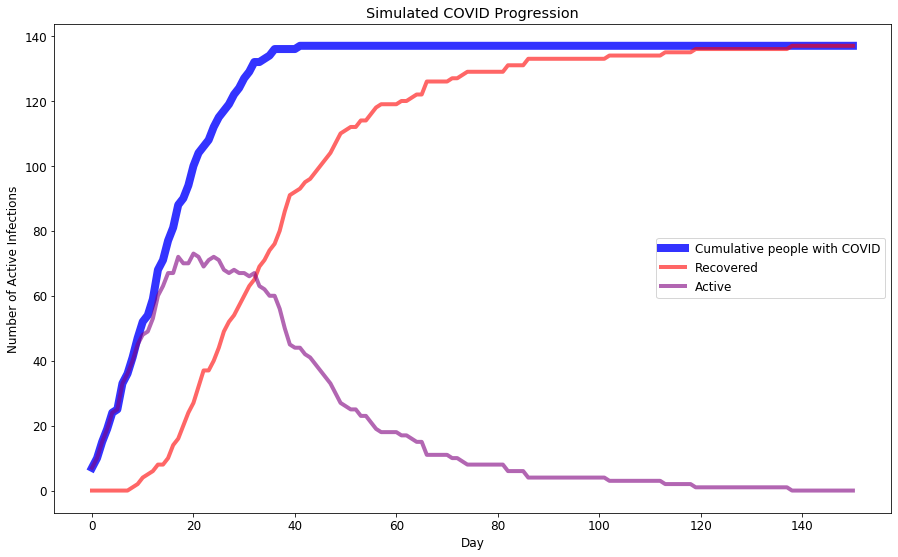

In [5]:
plt.figure(figsize=(15,9))
df_0 = dfs_sims[0]
# Plotting
cumulative_cols = ['QI','R'] + ['E_{}'.format(x) for x in range(params['max_time_exposed'])] + \
                ['ID_{}'.format(x) for x in range(params['max_time_ID'])] + \
                ['pre_ID_{}'.format(x) for x in range(params['max_time_pre_ID'])] + \
                ['SyID_mild_{}'.format(x) for x in range(params['max_time_SyID_mild'])] + \
                ['SyID_severe_{}'.format(x) for x in range(params['max_time_SyID_severe'])]
recovered_cols = ['R']
active_cols = ['QI'] + ['E_{}'.format(x) for x in range(params['max_time_exposed'])] + \
                ['ID_{}'.format(x) for x in range(params['max_time_ID'])] + \
                ['pre_ID_{}'.format(x) for x in range(params['max_time_pre_ID'])] + \
                ['SyID_mild_{}'.format(x) for x in range(params['max_time_SyID_mild'])] + \
                ['SyID_severe_{}'.format(x) for x in range(params['max_time_SyID_severe'])]
plt.plot(df_0[cumulative_cols].sum(axis=1), linewidth=8.0, alpha=0.8, color='blue')
plt.plot(df_0[recovered_cols].sum(axis=1), linewidth=4.0, alpha=0.6, color='red')
plt.plot(df_0[active_cols].sum(axis=1), linewidth=4.0, alpha=0.6, color='purple')
plt.xlabel("Day")
plt.ylabel("Number of Active Infections")
plt.title('Simulated COVID Progression')
plt.legend(('Cumulative people with COVID', 'Recovered', 'Active'), loc='best')
df_0

# What if social distancing is less effective (25 % more contacts per day)?

In [6]:
# run 1 trajectory
params['expected_contacts_per_day'] = 1.25 * params['expected_contacts_per_day']
np.random.seed(15)
dfs_sims = run_multiple_trajectories(params, ntrajectories=1, time_horizon=150)

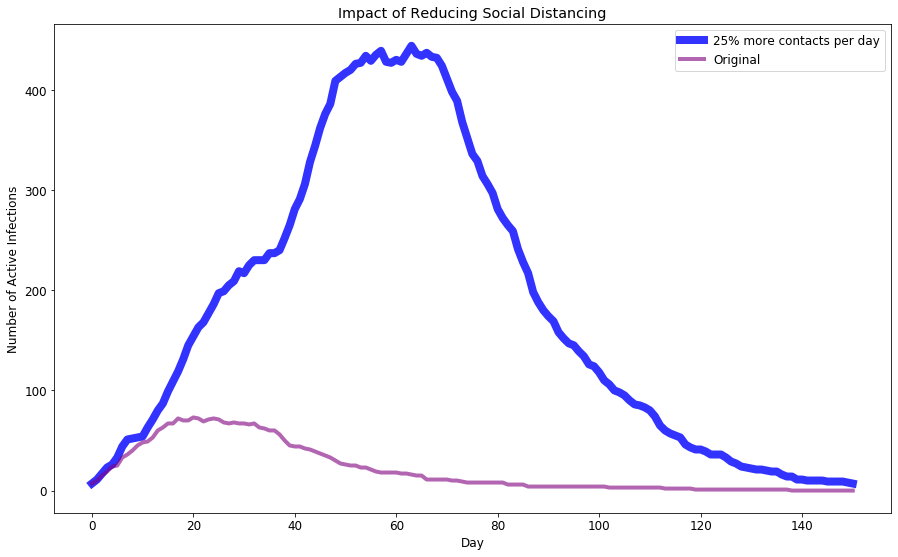

In [7]:
plt.figure(figsize=(15,9))
df_1 = dfs_sims[0]
plt.plot(df_1[active_cols].sum(axis=1), linewidth=8.0, alpha=0.8, color='blue')
plt.plot(df_0[active_cols].sum(axis=1), linewidth=4.0, alpha=0.6, color='purple')
plt.xlabel("Day")
plt.ylabel("Number of Active Infections")
plt.title('Impact of Reducing Social Distancing')
plt.legend(('25% more contacts per day', 'Original'), loc='best')

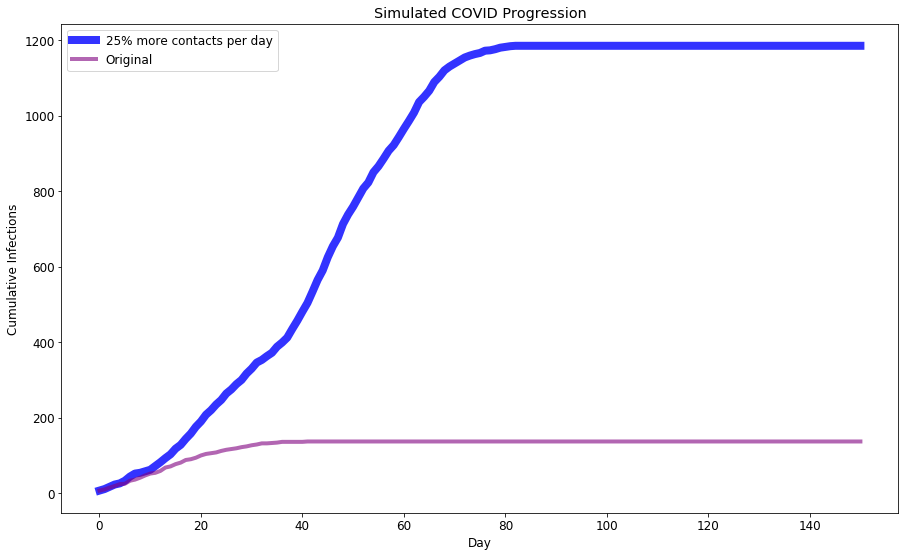

In [8]:
plt.figure(figsize=(15,9))
df_1 = dfs_sims[0]
plt.plot(df_1[cumulative_cols].sum(axis=1), linewidth=8.0, alpha=0.8, color='blue')
plt.plot(df_0[cumulative_cols].sum(axis=1), linewidth=4.0, alpha=0.6, color='purple')
plt.xlabel("Day")
plt.ylabel("Cumulative Infections")
plt.title('Simulated COVID Progression')
plt.legend(('25% more contacts per day', 'Original'), loc='best')

# Different Metrics

Text(0, 0.5, 'Cumulative People in each severity class')

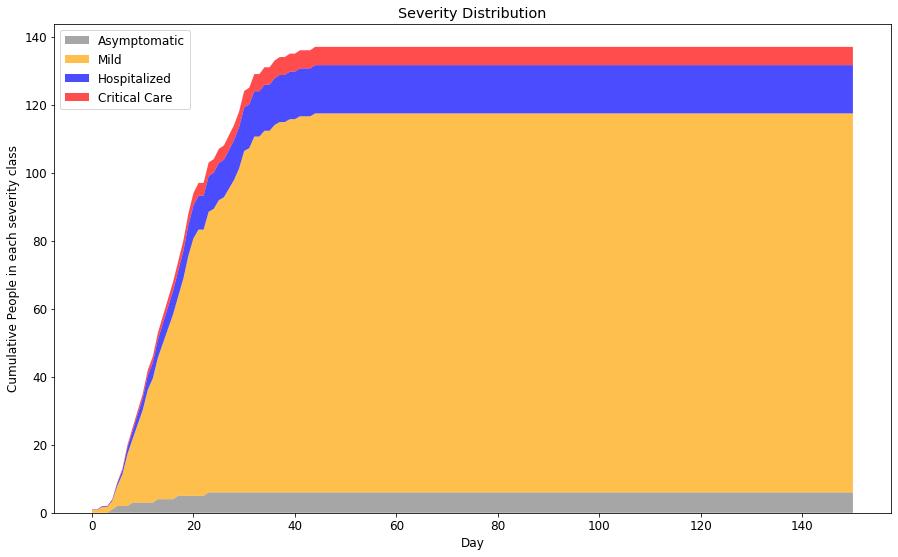

In [9]:
# Metric: Area graph of the number of people in each severity state
plt.figure(figsize=(15,9))
y0 = list(df_0['severity_0'])
y1 = list(df_0['severity_1'])
y2 = list(df_0['severity_2'])
y3 = list(df_0['severity_3'])
x = list(range(len(list(df_0['severity_0']))))

plt.stackplot(x, y0,y1,y2,y3, labels=['Asymptomatic','Mild','Hospitalized','Critical Care'], alpha=0.7, colors=['grey', 'orange', 'blue', 'red']*10)
plt.legend(loc='upper left')
plt.title('Severity Distribution')
plt.xlabel('Day')
plt.ylabel('Cumulative People in each severity class')

# print(list(df_0['severity_0']), list(df_0['severity_1']), list(df_0['severity_2']), list(df_0['severity_3']))
# print(list(range(len(list(df_0['severity_0'])))))

# What about with Contact Tracing?

In [10]:
params = base_params.copy()
params['perform_contact_tracing'] = True

# run 1 trajectory
np.random.seed(15)
dfs_sims = run_multiple_trajectories(params, ntrajectories=1, time_horizon=150)

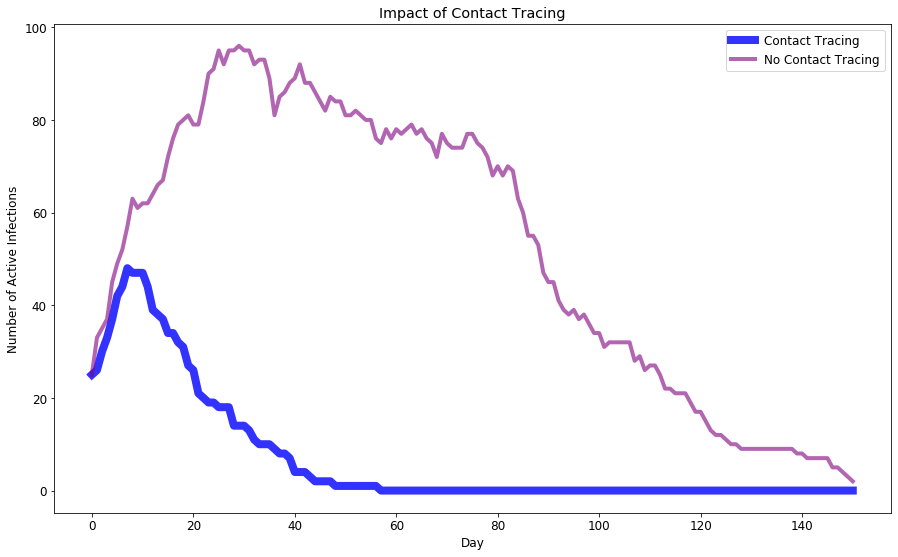

In [11]:
df_ct = dfs_sims[0]
plt.figure(figsize=(15,9))
# df_1 = dfs_sims[0]
plt.plot(df_ct[active_cols].sum(axis=1), linewidth=8.0, alpha=0.8, color='blue')
plt.plot(df_0[active_cols].sum(axis=1), linewidth=4.0, alpha=0.6, color='purple')
plt.xlabel("Day")
plt.ylabel("Number of Active Infections")
plt.title('Impact of Contact Tracing')
plt.legend(('Contact Tracing', 'No Contact Tracing'), loc='best')

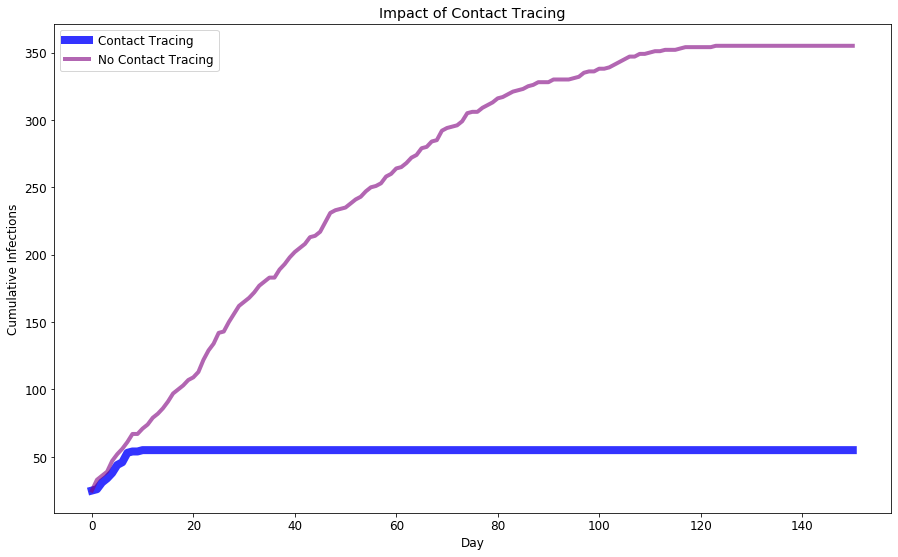

In [13]:
df_ct = dfs_sims[0]
plt.figure(figsize=(15,9))
# df_1 = dfs_sims[0]
plt.plot(df_ct[cumulative_cols].sum(axis=1), linewidth=8.0, alpha=0.8, color='blue')
plt.plot(df_0[cumulative_cols].sum(axis=1), linewidth=4.0, alpha=0.6, color='purple')
plt.xlabel("Day")
plt.ylabel("Cumulative Infections")
plt.title('Impact of Contact Tracing')
plt.legend(('Contact Tracing', 'No Contact Tracing'), loc='best')

# Cumulative Severity: Multiple trajectories

In [36]:
# run 1 trajectory
params = base_params.copy()
np.random.seed(15)
dfs_sims = run_multiple_trajectories(params, ntrajectories=5, time_horizon=150)

Text(0, 0.5, 'Cumulative People in each severity class')

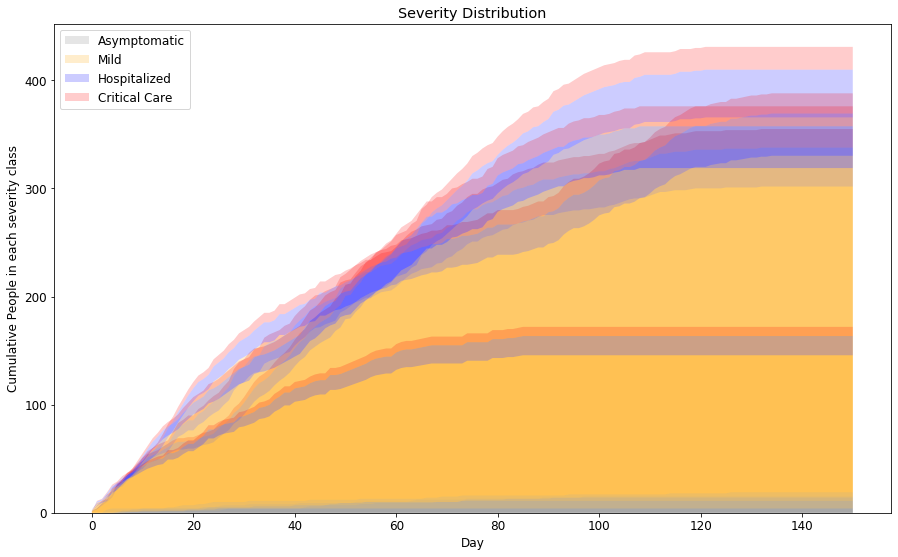

In [38]:
# Metric: Area graph of the number of people in each severity state
plt.figure(figsize=(15,9))

legend = False
for df in dfs_sims:
    y0 = list(df['severity_0'])
    y1 = list(df['severity_1'])
    y2 = list(df['severity_2'])
    y3 = list(df['severity_3'])
    x = list(range(len(list(df['severity_0']))))

    plt.stackplot(x, y0,y1,y2,y3, labels=['Asymptomatic','Mild','Hospitalized','Critical Care'], alpha=0.2, colors=['grey', 'orange', 'blue', 'red']*10)
    if legend == False:
        plt.legend(loc='upper left')
        legend = True

plt.title('Severity Distribution')
plt.xlabel('Day')
plt.ylabel('Cumulative People in each severity class')

# dfs_sims[0]
# dfs_sims[1]

# print(list(df_0['severity_0']), list(df_0['severity_1']), list(df_0['severity_2']), list(df_0['severity_3']))
# print(list(range(len(list(df_0['severity_0'])))))